## Absorption and PL

This analysis pipeline transforms raw 2D TIFF images from both spectroscopic and calibration measurements into fully calibrated, baseline-corrected absorption and photoluminescence (PL) spectra on a physically meaningful axis. Two narrow-band lamp images at 550 nm and 600 nm establish a linear pixel-to-wavelength mapping by locating the brightest pixel in each collapsed column profile; the resulting dispersion relation  

$$\lambda(\text{pixel}) = m\,\times\text{pixel} + b$$
  
provides an accurate conversion from detector column index to wavelength in nanometers.  

Each sample frame is then scanned vertically: rows whose summed intensity exceeds a small fraction of the maximum are identified as “signal,” while darker rows serve to estimate and subtract a uniform background. Within that signal region, adjustable-height strips (a few pixels tall each) are overlaid on the spectrometer image so that the same colored bands marking those rows appear on the raw TIFF. Averaging each strip’s rows yields a single, noise-reduced 1D intensity profile versus pixel position.  

For absorption measurements, both the sample and reference frames undergo this averaging step; the Beer–Lambert absorbance is computed as  

$$A(\lambda) = -\ln\!\bigl(I_{\rm sample}(\lambda)\,/\,I_{\rm reference}(\lambda)\bigr)$$
  
with any zero-division points masked out. Automatic peak finding then locates characteristic vibronic maxima, which are marked on the calibrated wavelength axis and reported numerically. In PL mode, the same background rows define a baseline that is subtracted from the emission strips before collapsing; any residual negative noise is clipped to zero so that the PL curve returns cleanly to zero off-peak.  

Fit equation is λ(x) = 1.5152x + 215.15
To check if the fit was properly done we fit the values and compute equation: λ(x550) = 550.0 nm; λ(x600) = 600.0 nm
Strip at row 153: peak absorbance 1.238 at 609.1 nm
Strip at row 175: peak absorbance 1.289 at 613.6 nm
Strip at row 198: peak absorbance 0.825 at 618.2 nm
Strip at row 221: peak absorbance 1.430 at 616.7 nm
Strip at row 244: peak absorbance 0.771 at 610.6 nm
Strip at row 266: peak absorbance 0.694 at 613.6 nm
Strip at row 289: peak absorbance 1.085 at 622.7 nm
Strip at row 312: peak absorbance 0.593 at 609.1 nm
Strip at row 335: peak absorbance 1.560 at 607.6 nm
Strip at row 358: peak absorbance 0.885 at 613.6 nm


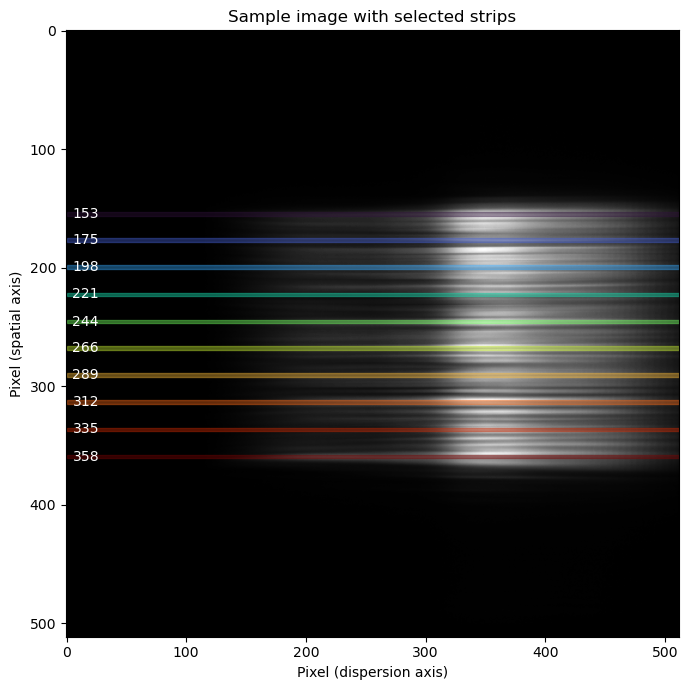

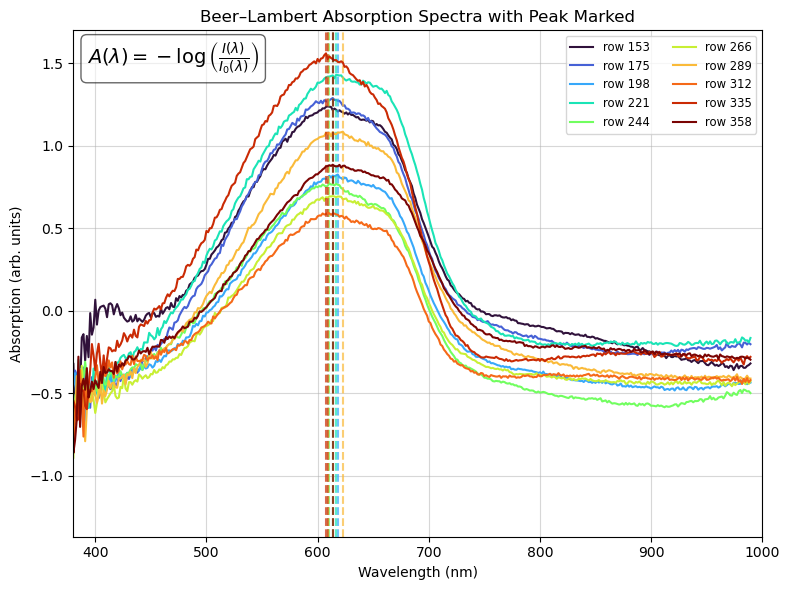

In [95]:
import numpy as np
import matplotlib.pyplot as plt
import tifffile
from matplotlib.patches import Rectangle

# ── Filenames ───────────────────────────────────────────────
sample_tif    = '19-5-2025(abs-pl_p(g2t-t)_ch+ac)/Position_20/position20_NIRlamp_spectra600_2s.tif'       # I(x,y) through sample
reference_tif = '19-5-2025(abs-pl_p(g2t-t)_ch+ac)/calibration/ref_NIRlamp_spectra600_2s.tif'             # I0(x,y) without sample
cal600_tif    = '19-5-2025(abs-pl_p(g2t-t)_ch+ac)/calibration/cali_laser600_spectra600_0.001s.tif'         # calibration image with 600 nm peak at center
cal550_tif    = '19-5-2025(abs-pl_p(g2t-t)_ch+ac)/calibration/cali_laser550_spectra600_0.001s.tif'         # calibration image with 550 nm peak off-center

# ── Load images ─────────────────────────────────────────────
I    = tifffile.imread(sample_tif).astype(float)
I0   = tifffile.imread(reference_tif).astype(float)
C600 = tifffile.imread(cal600_tif).astype(float)
C550 = tifffile.imread(cal550_tif).astype(float)

# ── Build pixel -> wavelength mapping ───────────────────────
x600 = np.argmax(C600.mean(axis=0))                         # Average all columns and make them collapse in a single 1D row. Then take the brighest pixel 
x550 = np.argmax(C550.mean(axis=0))                         # corresponding to central λ
m    = (600.0 - 550.0) / (x600 - x550)
b    = 600.0 - m * x600
wavelength = m * np.arange(I.shape[1]) + b                  # Plotting the line that goes through the anchor points 
print(f"Fit equation is λ(x) = {m:.4f}x + {b:.2f}")
print("To check if the fit was properly done we fit the values and compute equation: λ(x550) =", m*x550 + b, "nm; λ(x600) =", m*x600 + b, "nm")

# ── Locate vertical span of signal ──────────────────────────
row_sums    = I.sum(axis=1)                                 # Add up every row of the sample spectrum
thr         = 0.70 * row_sums.max()                         # Consider only the rows brighter than x% of the brightest row (threshold)
signal_rows = np.where(row_sums > thr)[0]                   # Take the indeces of those rows
rmin, rmax  = signal_rows.min(), signal_rows.max()          # Get the highest & lowest band. Samples are going in between

# ── Select a specific amount of strips ──────────────────────
strip_h  = 3                                                # Height of each strip in pixels

# Option A: pick exactly N strips evenly spaced between rmin and rmax
n_strips = 10
rows_to_sample = np.linspace(rmin, rmax-strip_h, n_strips, dtype=int)
# Option B: pick strips every M amount of pixels starting at rmin
#step_pix = 5
# rows_to_sample = np.arange(rmin, rmax - strip_h + 1, step_pix, dtype=int)  

# Colors for plotting / overlay
colors = plt.cm.turbo(np.linspace(0,1,n_strips))           # Can choose between viridis, jet, rainbow, turbo, gist_ncar

# ── Plot the sample image with overlayed strips ────────────
fig, ax = plt.subplots(figsize=(7,7))
ax.imshow(I, cmap='gray', aspect='auto')
for r, c in zip(rows_to_sample, colors):                   # For each x pixels-high strip
    rect = Rectangle((0, r), I.shape[1], strip_h,          # Draw on the image a semi-translucent rectangle of the area analysed
                     linewidth=1, edgecolor=c, facecolor=c, alpha=0.4)
    ax.add_patch(rect)                                          
    ax.text(5, r+strip_h/2, f"{r}", color='white', va='center') # Annotate strip number
ax.set_title('Sample image with selected strips')
ax.set_xlabel('Pixel (dispersion axis)')
ax.set_ylabel('Pixel (spatial axis)')
plt.tight_layout()

# ── Compute Beer–Lambert Law for each strip ───────────────
profiles = []
for r in rows_to_sample:
    I_strip  = I[r:r+strip_h, :].mean(axis=0)              # Average the x pixel-high strip into a 1D row
    I0_strip = I0[r:r+strip_h, :].mean(axis=0)
    mask     = I0_strip > 0                                # Avoid dividing by 0 or taking log(0)
    A        = np.full_like(I_strip, np.nan)
    A[mask]  = -np.log(I_strip[mask] / I0_strip[mask])     # Calculate the Beer–Lambert Law
    profiles.append((r, A))

# ── Plot absorption spectra ──────────────────────────────
fig1, ax = plt.subplots(figsize=(8,6))

for (r, A), c in zip(profiles, colors):
    ax.plot(wavelength, A, color=c, label=f"row {r}")
    idx_peak   = np.nanargmax(A)                           # Find the peak
    lambda_peak = wavelength[idx_peak]
    A_peak      = A[idx_peak]
    print(f"Strip at row {r:3d}: peak absorbance {A_peak:.3f} at {lambda_peak:.1f} nm")
    ax.axvline(lambda_peak, color=c, linestyle='--', alpha=0.7) # Draw a vertical line at the peak

# Final formatting
ax.text(0.02, 0.98,                                        # x, y in axes‐fraction coordinates
    r"$A(\lambda) = -\log \left( \frac{I(\lambda)}{I_0(\lambda)} \right)$",
    transform=ax.transAxes,                                # Interpret x,y as fraction of axes
    fontsize=14,                           
    va="top",                                              # Vertical alignment
    ha="left",                                             # Horizontal alignment
    bbox=dict(boxstyle="round,pad=0.3",                    # Formula in a box  
              facecolor="white", alpha=0.6))
ax.set_xlim(380, 1000)                                     # Crop noisy ends
# Optional tight y-axis fit
# ax.set_ylim(-0.1, np.nanmax([A.max() for _, A in profiles])*1.1)
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel('Absorption (arb. units)')
ax.set_title('Beer–Lambert Absorption Spectra with Peak Marked')
ax.grid(True, linestyle='-', alpha=0.5)
ax.legend(ncol=2, fontsize='small', loc='upper right')
plt.tight_layout()
plt.show()
fig1.savefig('19-5-2025(abs-pl_p(g2t-t)_ch+ac)/Position_20/Position20_absorption_spectra.png', dpi=300, bbox_inches='tight')
fig.savefig('19-5-2025(abs-pl_p(g2t-t)_ch+ac)/Position_20/Position20_sample_with_strips.png', dpi=300, bbox_inches='tight')

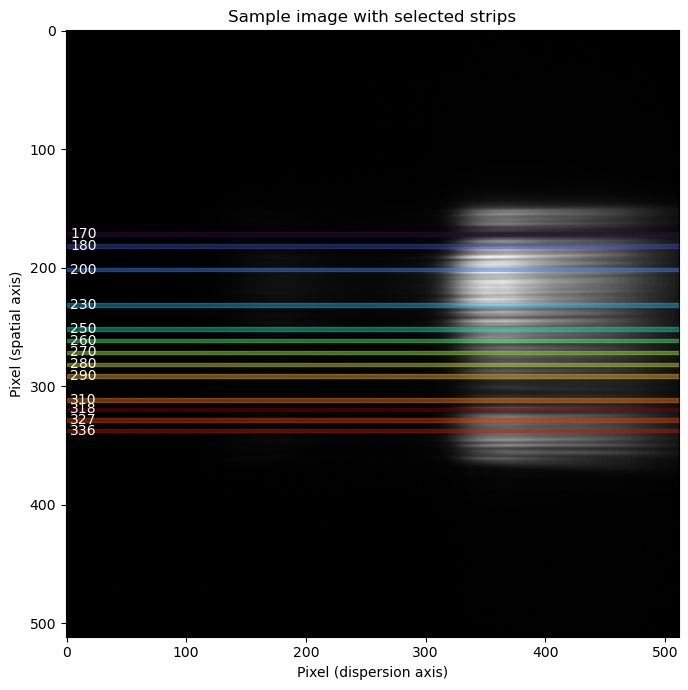

Strip at row 170: peak absorbance 3.827 at 636.4 nm
Strip at row 180: peak absorbance 3.670 at 640.9 nm
Strip at row 200: peak absorbance 2.719 at 609.1 nm
Strip at row 230: peak absorbance 2.665 at 610.6 nm
Strip at row 250: peak absorbance 2.729 at 607.6 nm
Strip at row 260: peak absorbance 3.518 at 625.8 nm
Strip at row 270: peak absorbance 3.610 at 640.9 nm
Strip at row 280: peak absorbance 3.537 at 613.6 nm
Strip at row 290: peak absorbance 3.775 at 647.0 nm
Strip at row 310: peak absorbance 3.796 at 647.0 nm
Strip at row 327: peak absorbance 3.739 at 624.2 nm
Strip at row 336: peak absorbance 3.677 at 615.2 nm
Strip at row 318: peak absorbance 3.730 at 637.9 nm


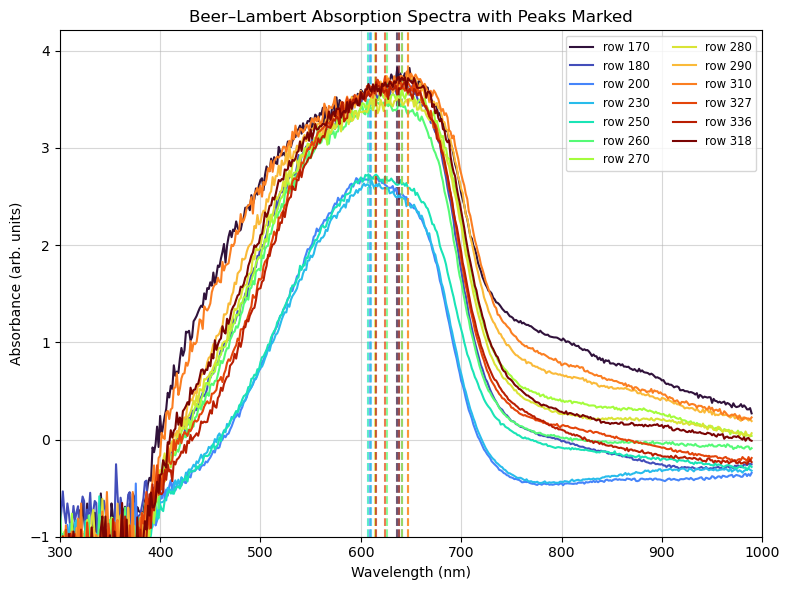

In [87]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# ── User selects row(s) here ────────────────────────────────
pixel_rows = [ 170, 180, 200, 230, 250, 260, 270, 280, 290, 310, 327, 336, 318]
strip_h    = 3   # strip height in pixels

# ── Make a color for each strip ─────────────────────────────
colors = plt.cm.turbo(np.linspace(0,1,len(pixel_rows)))

# ── Plot the spectrometer image with colored strips ──────────
fig3, ax = plt.subplots(figsize=(7,7))
ax.imshow(I, cmap='gray', aspect='auto')
for r, c in zip(pixel_rows, colors):
    rect = Rectangle((0, r), I.shape[1], strip_h,
                     edgecolor=c, facecolor=c, alpha=0.4, linewidth=1)
    ax.add_patch(rect)
    ax.text(3, r+strip_h/2, f"{r}", color='white', va='center')
ax.set_title('Sample image with selected strips')
ax.set_xlabel('Pixel (dispersion axis)')
ax.set_ylabel('Pixel (spatial axis)')
plt.tight_layout()
plt.show()

# ── Compute absorbance & peak for each strip ────────────────
profiles = []
for r in pixel_rows:
    # average the 3-pixel strip in sample & reference
    I_strip  = I [r:r+strip_h, :].mean(axis=0)
    I0_strip = I0[r:r+strip_h, :].mean(axis=0)
    
    # Beer–Lambert
    mask = I0_strip > 0
    A    = np.full_like(I_strip, np.nan)
    A[mask] = -np.log(I_strip[mask] / I0_strip[mask])
    
    # find peak
    idx_peak    = np.nanargmax(A)
    lambda_peak = m*idx_peak + b
    A_peak      = A[idx_peak]
    print(f"Strip at row {r:3d}: peak absorbance {A_peak:.3f} at {lambda_peak:.1f} nm")
    
    profiles.append((r, A, idx_peak))

# ── Plot absorbance spectra with peak lines ─────────────────
fig4, ax = plt.subplots(figsize=(8,6))
for (r, A, idx_peak), c in zip(profiles, colors):
    lam = m * np.arange(A.size) + b
    ax.plot(lam, A, color=c, label=f'row {r}')
    # draw vertical line at the peak
    lam_peak = lam[idx_peak]
    ax.axvline(lam_peak, color=c, linestyle='--', alpha=0.7)

ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel('Absorbance (arb. units)')
ax.set_title('Beer–Lambert Absorption Spectra with Peaks Marked')
ax.set_xlim(300, 1000)
ax.set_ylim(-1, np.nanmax([A.max() for _,A,_ in profiles])*1.1)

ax.grid(True, ls='-', alpha=0.5)
ax.legend(ncol=2, fontsize='small', loc='upper right')
plt.tight_layout()
plt.show()
fig4.savefig('19-5-2025(abs-pl_p(g2t-t)_ch+ac)/Position_18/Position18_specific_absorption_spectra.png', dpi=300, bbox_inches='tight')
fig3.savefig('19-5-2025(abs-pl_p(g2t-t)_ch+ac)/Position_18/Position18_sample_with_specific_strips.png', dpi=300, bbox_inches='tight')

Fit equation is λ(x) = 1.5152x + 215.15
To check if the fit was properly done we fit the values and compute equation: λ(x550) = 550.0 nm; λ(x600) = 600.0 nm


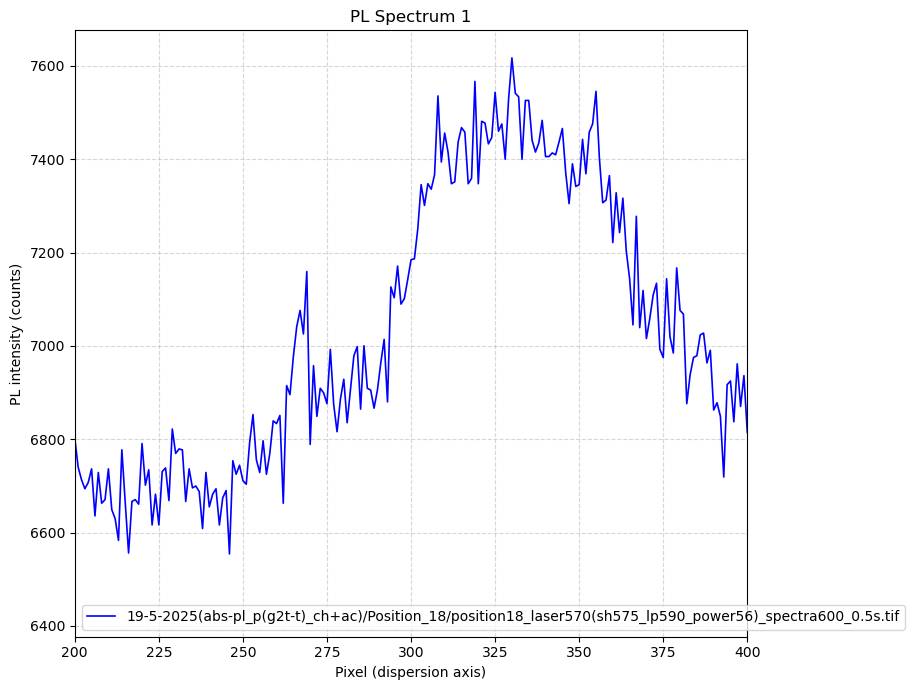

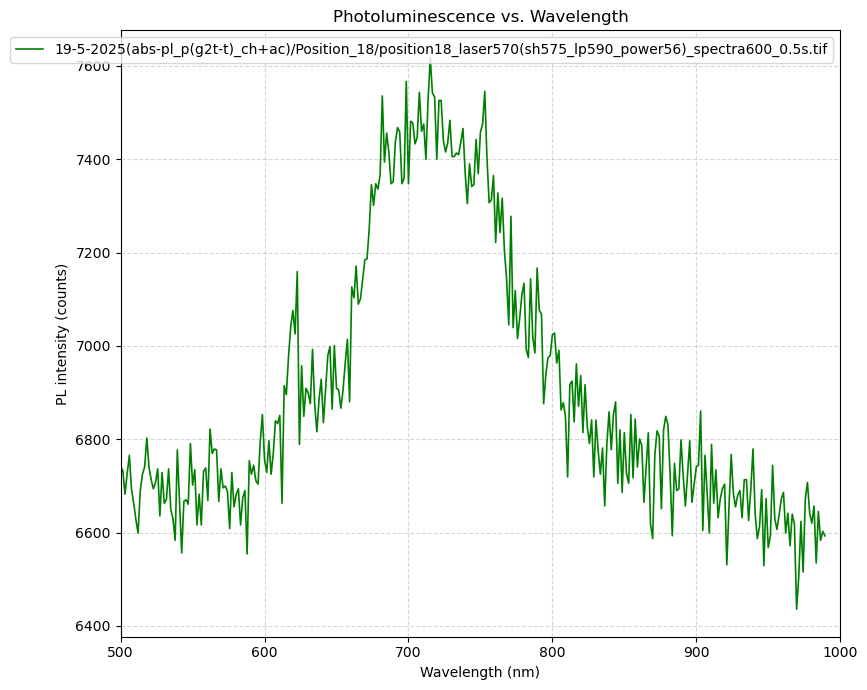

In [91]:
import numpy as np
import matplotlib.pyplot as plt
import tifffile

# ── Filenames ────────────────────────────────────────────────
pl1_tif = '19-5-2025(abs-pl_p(g2t-t)_ch+ac)/Position_20/position20_laser570(sh575_lp590_power56)_spectra600_0.5s.tif'   
#pl2_tif = 'position6_laser(570_54)SH757_LP590_spectra600_0.5s.tif'   

# ── Helper to load & extract 1D spectrum ────────────────────
def extract_spectrum(tif_path, threshold_frac=0.1):
    """
    Loads a grayscale TIFF, finds rows above threshold_frac*max(row_sum),
    averages those rows to a single 1D profile, and returns (cols, profile).
    """
    img = tifffile.imread(tif_path).astype(float)
    row_sums = img.sum(axis=1)                                     # Sum each row → 1D array of length n_rows
    thr = threshold_frac * row_sums.max()                          # Rows below this value are considered as background
    sig_rows = np.where(row_sums > thr)[0]                         # The ones above that value are considered as signal
    if sig_rows.size == 0:
        raise ValueError(f"No signal found in {tif_path!r}")       # If no rows pass the threshold it returns an error
    rmin, rmax = sig_rows.min(), sig_rows.max()                    
    profile = img[rmin:rmax+1, :].mean(axis=0)                     # Collapse all signal rows to 1D by averaging
    return np.arange(profile.size), profile


# ── Build pixel -> wavelength mapping ───────────────────────
PL = tifffile.imread(pl1_tif).astype(float)
x600 = np.argmax(C600.mean(axis=0))                         # Average all columns and make them collapse in a single 1D row. Then take the brighest pixel 
x550 = np.argmax(C550.mean(axis=0))                         # corresponding to central λ
m    = (600.0 - 550.0) / (x600 - x550)
b    = 600.0 - m * x600
wavelength = m * np.arange(PL.shape[1]) + b                  # Plotting the line that goes through the anchor points 
print(f"Fit equation is λ(x) = {m:.4f}x + {b:.2f}")
print("To check if the fit was properly done we fit the values and compute equation: λ(x550) =", m*x550 + b, "nm; λ(x600) =", m*x600 + b, "nm")

# ── Plot first spectrum ──────────────────────────────────────
x1, y1 = extract_spectrum(pl1_tif)
fig5, ax = plt.subplots(figsize=(9,7))
ax.plot(x1, y1, lw=1.2, color='b', label=pl1_tif)
ax.set_xlim(200, 400)
ax.set_xlabel('Pixel (dispersion axis)')
ax.set_ylabel('PL intensity (counts)')
ax.set_title('PL Spectrum 1')
ax.grid(True, ls='--', alpha=0.5)
ax.legend()
plt.tight_layout()

fig6, ax = plt.subplots(figsize=(9,7))
ax.plot(wavelength, y1, lw=1.2, color='g', label=pl1_tif)
ax.set_xlim(500, 1000)
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel('PL intensity (counts)')
ax.set_title('Photoluminescence vs. Wavelength')
ax.grid(True, ls='--', alpha=0.5)
ax.legend()
plt.tight_layout()

plt.show()

# ── Plot second spectrum (if present) ────────────────────────
# Simply uncomment these lines if there is a second image
#x2, y2 = extract_spectrum(pl2_tif)
#fig, ax = plt.subplots(figsize=(10,7))
#ax.plot(x2, y2, lw=1.2, label=pl1_tif)
#ax.set_xlim(200, 400)
#ax.set_xlabel('Pixel (dispersion axis)')
#ax.set_ylabel('Intensity (arb. units)')
#ax.set_title('PL Spectrum 1')
#ax.grid(True, ls='--', alpha=0.5)
#ax.legend()
#plt.tight_layout()
fig5.savefig('19-5-2025(abs-pl_p(g2t-t)_ch+ac)/Position_20/Position20_PL_spectrum.png', dpi=300, bbox_inches='tight')
fig6.savefig('19-5-2025(abs-pl_p(g2t-t)_ch+ac)/Position_20/Position20_PL_spectrum Wavelength.png', dpi=300, bbox_inches='tight')